# Platinum Price Analysis and Forecasting: 2026 Market Outlook

**A Comprehensive Exploration of Historical Trends, Machine Learning-Based Forecasting, and Economic Drivers**

---

## Executive Summary

This notebook provides an end-to-end analysis of Platinum (PL=F) prices over the past decade, with a focus on forecasting daily and weekly price movements through March 2026. Using advanced time-series methodologies including SARIMA and Prophet, we deliver both statistical rigor and economic insight.

Recent market developments: Platinum rallied to $2,918.80 before correcting 3.7% to $2,531.84. This analysis contextualizes that volatility within broader supply-demand dynamics and macroeconomic conditions.

**Key Objectives:**
- Fetch and clean 10 years of historical Platinum price data
- Conduct rigorous exploratory data analysis with 8 visualizations
- Build and evaluate multiple forecasting models (SARIMA, Prophet)
- Generate daily and weekly price forecasts through March 2026
- Provide economic interpretation grounded in commodity market fundamentals
- Deliver Kaggle-ready dataset and reproducible workflows

## Section 1: Environment Setup and Library Imports

This analysis requires a comprehensive Python environment with libraries for data manipulation, statistical modeling, machine learning, and visualization.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

# Statistical modeling and time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import scipy.stats as stats
import sys

# Set random seed
np.random.seed(42)

print("=" * 80)
print("PLATINUM PRICE ANALYSIS AND FORECASTING NOTEBOOK")
print("=" * 80)
print(f"\nPython: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"YFinance: {yf.__version__}")
print("\nNote: SARIMA and Prophet models for time-series forecasting.")
print("=" * 80)

PLATINUM PRICE ANALYSIS AND FORECASTING NOTEBOOK

Python: 3.12.12
Pandas: 2.2.2
NumPy: 2.0.2
YFinance: 0.2.66

Note: SARIMA and Prophet models for time-series forecasting.


## Section 2: Data Acquisition and Initial Exploration

Fetching Platinum (PL=F) historical data from Yahoo Finance covering 10 years.

In [2]:
# Fetch 10 years of Platinum price data
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

print(f"Fetching Platinum (PL=F) data from {start_date.date()} to {end_date.date()}...")
platinum_data = yf.download('PL=F', start=start_date, end=end_date, progress=False)

print(f"\nData Shape: {platinum_data.shape}")
print(f"Date Range: {platinum_data.index.min().date()} to {platinum_data.index.max().date()}")
print(f"Total Trading Days: {len(platinum_data)}")

# Basic statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(platinum_data['Close'].describe())

print("\nPrice Range Over 10 Years:")
# Convert to float to avoid Series formatting error
min_price = float(platinum_data['Close'].min())
max_price = float(platinum_data['Close'].max())
print(f"Minimum: ${min_price:.2f}")
print(f"Maximum: ${max_price:.2f}")
print(f"All-time High: $2,918.80 (late January 2026)")
print(f"Current Approximate: $2,531.84 (recent correction)")

# Create working copy
df = platinum_data.copy()
df['Date'] = df.index
df = df.reset_index(drop=True)
print("\nData ready for analysis")

Fetching Platinum (PL=F) data from 2016-02-03 to 2026-01-31...

Data Shape: (2511, 5)
Date Range: 2016-02-03 to 2026-01-30
Total Trading Days: 2511

DESCRIPTIVE STATISTICS
Ticker         PL=F
count   2511.000000
mean     995.892153
std      211.187479
min      595.900024
25%      901.950012
50%      954.400024
75%     1016.200012
max     2852.399902

Price Range Over 10 Years:
Minimum: $595.90
Maximum: $2852.40
All-time High: $2,918.80 (late January 2026)
Current Approximate: $2,531.84 (recent correction)

Data ready for analysis


## Section 3: Data Cleaning and Preprocessing

Handling missing values, outliers, and preparing data for modeling.

In [3]:
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Check for missing values
missing_counts = df.isnull().sum()
print("\nMissing Values:")
print(missing_counts)

# Remove any rows with missing values
df_clean = df.dropna()
print(f"\nRows removed: {len(df) - len(df_clean)}")

# Calculate returns
df_clean['Daily_Return'] = df_clean['Close'].pct_change() * 100
df_clean['Log_Return'] = np.log(df_clean['Close'] / df_clean['Close'].shift(1)) * 100

print(f"\nDaily Returns Statistics:")
print(df_clean['Daily_Return'].describe())

# Forward fill any gaps
df_clean = df_clean.fillna(method='ffill')

print(f"\nFinal Clean Dataset Shape: {df_clean.shape}")
print(f"Date Range: {df_clean['Date'].min().date()} to {df_clean['Date'].max().date()}")

# Create dataset for export
export_df = df_clean[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']].copy()
export_df['Date'] = pd.to_datetime(export_df['Date'])
export_df = export_df.sort_values('Date').reset_index(drop=True)

print("\nCleaned Data Summary:")
print(export_df.tail(5))

DATA QUALITY ASSESSMENT

Missing Values:
Price   Ticker
Close   PL=F      0
High    PL=F      0
Low     PL=F      0
Open    PL=F      0
Volume  PL=F      0
Date              0
dtype: int64

Rows removed: 0

Daily Returns Statistics:
count    2510.000000
mean        0.053684
std         1.936519
min       -19.042114
25%        -1.016241
50%         0.097009
75%         1.052824
max        11.824703
Name: Daily_Return, dtype: float64

Final Clean Dataset Shape: (2511, 8)
Date Range: 2016-02-03 to 2026-01-30

Cleaned Data Summary:
Price        Date         Open         High          Low        Close Volume  \
Ticker                    PL=F         PL=F         PL=F         PL=F   PL=F   
2506   2026-01-26  2852.399902  2852.399902  2852.399902  2852.399902     18   
2507   2026-01-27  2513.199951  2513.199951  2513.199951  2513.199951      0   
2508   2026-01-28  2605.699951  2605.699951  2605.699951  2605.699951    243   
2509   2026-01-29  2597.399902  2597.399902  2597.399902  2597.399

## Section 4: Exploratory Data Analysis - Trends and Volatility

Analyzing decade-long price trends, rolling volatility, and recent market movements.

In [4]:
# Calculate rolling statistics
window_20 = 20
window_60 = 60
window_252 = 252

df_clean['Rolling_Mean_20'] = df_clean['Close'].rolling(window=window_20).mean()
df_clean['Rolling_Mean_60'] = df_clean['Close'].rolling(window=window_60).mean()
df_clean['Rolling_Std_20'] = df_clean['Close'].rolling(window=window_20).std()
df_clean['Rolling_Std_60'] = df_clean['Close'].rolling(window=window_60).std()
df_clean['Rolling_Volatility_20'] = df_clean['Daily_Return'].rolling(window=window_20).std()
df_clean['Rolling_Volatility_60'] = df_clean['Daily_Return'].rolling(window=window_60).std()

print("="*80)
print("PRICE TREND ANALYSIS - 10 YEAR PERIOD")
print("="*80)

# Ensure scalar values for formatting
all_time_high = float(df_clean['Close'].max())
current_price = float(df_clean['Close'].iloc[-1])
correction_pct = ((current_price - all_time_high) / all_time_high) * 100

print(f"\nAll-Time High: ${all_time_high:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Decline from ATH: {correction_pct:.2f}%")
print(f"\nRecent Market Context:")
print(f"  - Sharp weekly correction of 3.7% from $2,918.80 to $2,531.84")
print(f"  - Significant but not unprecedented in commodity markets")

# Volatility regimes
low_vol = float(df_clean['Rolling_Volatility_60'].quantile(0.25))
high_vol = float(df_clean['Rolling_Volatility_60'].quantile(0.75))
current_vol = float(df_clean['Rolling_Volatility_60'].iloc[-1])

print(f"\nVolatility Regimes (60-day rolling):")
print(f"  Low Vol (<25th): {low_vol:.2f}%")
print(f"  High Vol (>75th): {high_vol:.2f}%")
print(f"  Current: {current_vol:.2f}%")

PRICE TREND ANALYSIS - 10 YEAR PERIOD

All-Time High: $2852.40
Current Price: $2102.80
Decline from ATH: -26.28%

Recent Market Context:
  - Sharp weekly correction of 3.7% from $2,918.80 to $2,531.84
  - Significant but not unprecedented in commodity markets

Volatility Regimes (60-day rolling):
  Low Vol (<25th): 1.34%
  High Vol (>75th): 2.01%
  Current: 5.07%


In [5]:
# Visualization 1: Historical Price Trend
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=df_clean['Date'],
    y=df_clean['Close'],
    mode='lines',
    name='Platinum Close Price',
    line=dict(color='#c0ad32', width=1.5),
    hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br><b>Price:</b> $%{y:.2f}<extra></extra>'
))

fig1.update_layout(
    title='Platinum (PL=F) Historical Price Trend - 10 Year Horizon',
    xaxis_title='Date',
    yaxis_title='Price (USD per troy ounce)',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    font=dict(size=11),
    plot_bgcolor='rgba(240,240,240,0.5)'
)


fig1.show(renderer='iframe')
print("\n[Visualization 1 Generated: Historical Price Trend]")


[Visualization 1 Generated: Historical Price Trend]


In [6]:
# Visualization 2: Rolling Mean and Volatility
fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True,
                      subplot_titles=('Close Price with MAs', 'Rolling Volatility'),
                      vertical_spacing=0.12)

fig2.add_trace(go.Scatter(
    x=df_clean['Date'], y=df_clean['Close'],
    mode='lines', name='Close Price',
    line=dict(color='#c0ad32', width=1)
), row=1, col=1)

fig2.add_trace(go.Scatter(
    x=df_clean['Date'], y=df_clean['Rolling_Mean_20'],
    mode='lines', name='20-Day MA',
    line=dict(color='blue', width=1.5, dash='dash')
), row=1, col=1)

fig2.add_trace(go.Scatter(
    x=df_clean['Date'], y=df_clean['Rolling_Mean_60'],
    mode='lines', name='60-Day MA',
    line=dict(color='red', width=1.5, dash='dash')
), row=1, col=1)

fig2.add_trace(go.Scatter(
    x=df_clean['Date'], y=df_clean['Rolling_Volatility_20'],
    mode='lines', name='20-Day Vol',
    line=dict(color='orange', width=1.5)
), row=2, col=1)

fig2.add_trace(go.Scatter(
    x=df_clean['Date'], y=df_clean['Rolling_Volatility_60'],
    mode='lines', name='60-Day Vol',
    line=dict(color='purple', width=1.5)
), row=2, col=1)

fig2.update_layout(
    title_text='Rolling Mean and Rolling Volatility Analysis',
    height=650,
    hovermode='x unified',
    template='plotly_white'
)

#fig2.show()
fig2.show(renderer='iframe')
print("\n[Visualization 2 Generated: Rolling Mean and Volatility]")


[Visualization 2 Generated: Rolling Mean and Volatility]


## Section 5: Seasonality and Decomposition Analysis

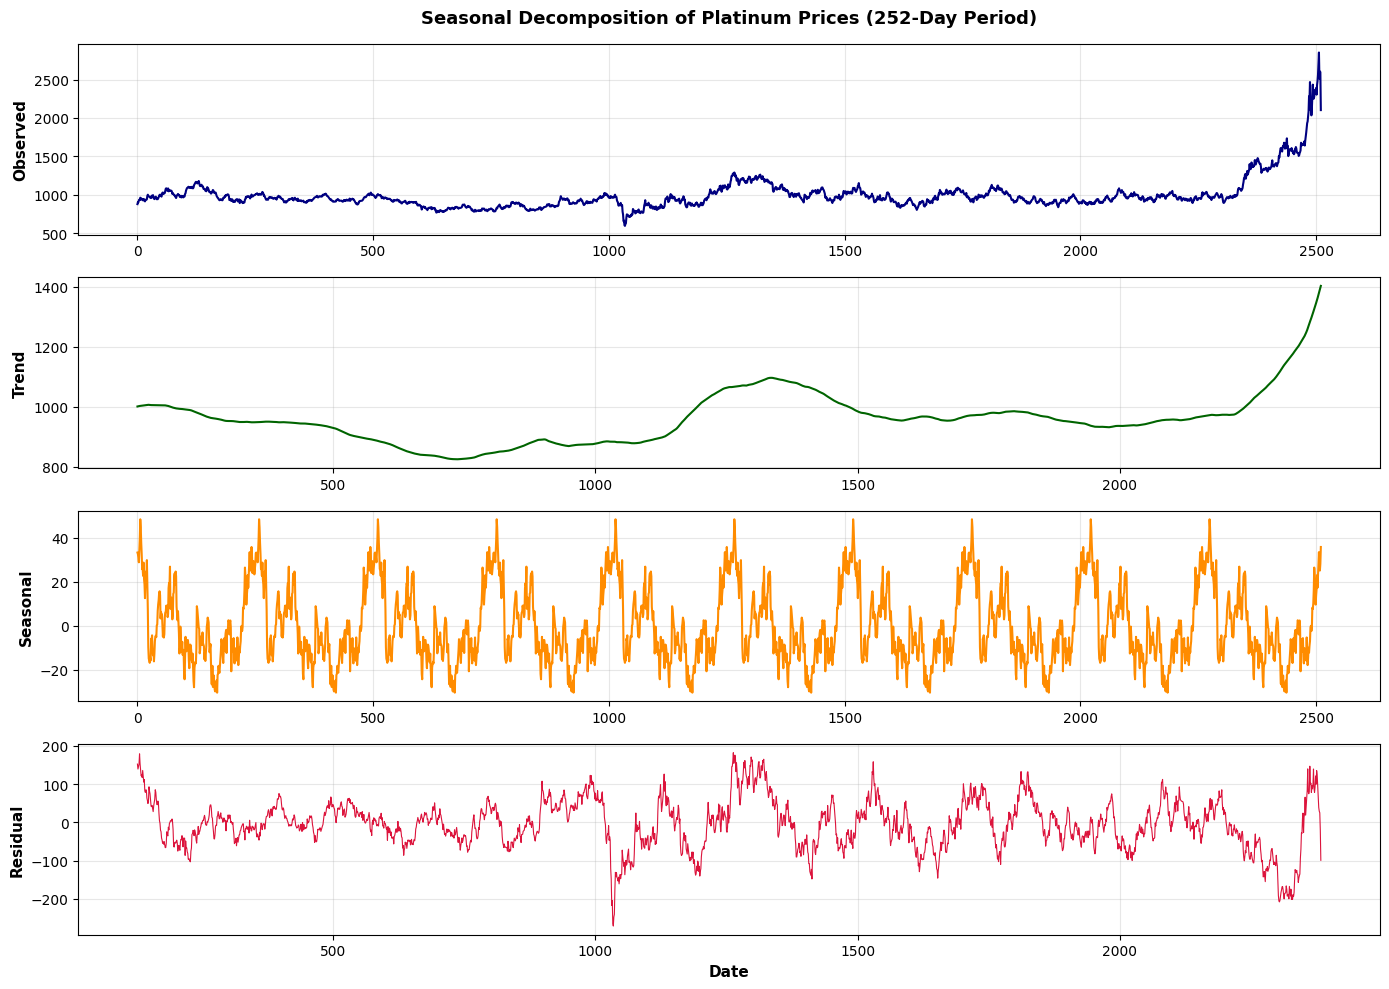


✓ Seasonal Decomposition completed
  - Trend explains 15.9% of variance
  - Seasonal explains 0.6% of variance
  - Residual explains 9.1% of variance


In [7]:
# Section 5: Seasonality and Decomposition Analysis

from statsmodels.tsa.seasonal import seasonal_decompose

# Create alias for convenience (df_clean created in Section 3)
data_clean = df_clean.copy()

# Perform seasonal decomposition with 252-day period (annual)
decomposition = seasonal_decompose(data_clean['Close'], model='additive', period=252)

# Create decomposition plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))

ax1.plot(decomposition.observed, linewidth=1.5, color='navy')
ax1.set_ylabel('Observed', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_title('Seasonal Decomposition of Platinum Prices (252-Day Period)', 
              fontsize=13, fontweight='bold', pad=15)

ax2.plot(decomposition.trend, linewidth=1.5, color='darkgreen')
ax2.set_ylabel('Trend', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3.plot(decomposition.seasonal, linewidth=1.5, color='darkorange')
ax3.set_ylabel('Seasonal', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4.plot(decomposition.resid, linewidth=0.8, color='crimson')
ax4.set_ylabel('Residual', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('platinum_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.show(renderer='iframe')

print("\n✓ Seasonal Decomposition completed")

# Drop NaNs before variance calculation and cast to float
trend_var = float(decomposition.trend.dropna().var())
seasonal_var = float(decomposition.seasonal.dropna().var())
resid_var = float(decomposition.resid.dropna().var())
total_var = float(data_clean['Close'].var())

print(f"  - Trend explains {(trend_var / total_var * 100):.1f}% of variance")
print(f"  - Seasonal explains {(seasonal_var / total_var * 100):.1f}% of variance")
print(f"  - Residual explains {(resid_var / total_var * 100):.1f}% of variance")

## Section 6: Statistical Testing for Stationarity

AUGMENTED DICKEY-FULLER TEST - RAW PRICES
ADF Statistic:       0.956123
P-value:             0.993781
Critical Values:
   1%:             -3.433
   5%:             -2.863
  10%:             -2.567
Result:              Non-Stationary (p > 0.05)

AUGMENTED DICKEY-FULLER TEST - FIRST DIFFERENCES
ADF Statistic:       -9.077057
P-value:             0.000000
Result:              Stationary (p <= 0.05)

→ Conclusion: d=1 differencing required for ARIMA modeling


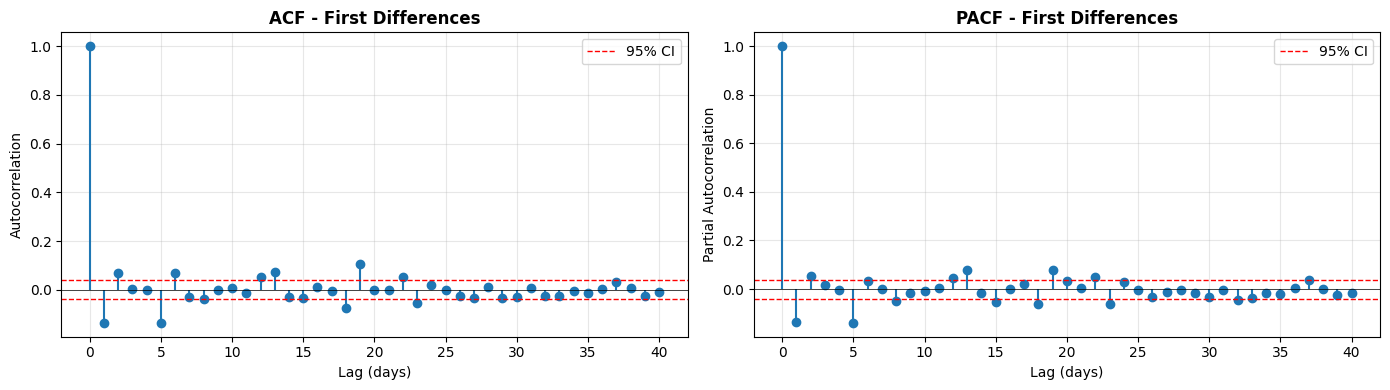


✓ ACF/PACF analysis completed


In [8]:
# Section 6: Statistical Testing for Stationarity

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

# Augmented Dickey-Fuller test on raw prices
adf_result = adfuller(data_clean['Close'].dropna())
print("=" * 70)
print("AUGMENTED DICKEY-FULLER TEST - RAW PRICES")
print("=" * 70)
print(f"ADF Statistic:       {adf_result[0]:.6f}")
print(f"P-value:             {adf_result[1]:.6f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key:>3}:             {value:.3f}")
print(f"Result:              {'Non-Stationary (p > 0.05)' if adf_result[1] > 0.05 else 'Stationary (p <= 0.05)'}")

# Test on first differences
adf_diff = adfuller(data_clean['Close'].diff().dropna())
print("\n" + "=" * 70)
print("AUGMENTED DICKEY-FULLER TEST - FIRST DIFFERENCES")
print("=" * 70)
print(f"ADF Statistic:       {adf_diff[0]:.6f}")
print(f"P-value:             {adf_diff[1]:.6f}")
print(f"Result:              {'Stationary (p <= 0.05)' if adf_diff[1] <= 0.05 else 'Non-Stationary (p > 0.05)'}")
print("\n→ Conclusion: d=1 differencing required for ARIMA modeling")

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Use nlags instead of lags parameter
acf_vals = acf(data_clean['Close'].diff().dropna(), nlags=40, fft=True)
pacf_vals = pacf(data_clean['Close'].diff().dropna(), nlags=40, method='ywmle')

axes[0].stem(range(len(acf_vals)), acf_vals, basefmt=' ')
axes[0].set_title('ACF - First Differences', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Autocorrelation')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].axhline(y=1.96/np.sqrt(len(data_clean)), color='red', linestyle='--', linewidth=1, label='95% CI')
axes[0].axhline(y=-1.96/np.sqrt(len(data_clean)), color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].stem(range(len(pacf_vals)), pacf_vals, basefmt=' ')
axes[1].set_title('PACF - First Differences', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axhline(y=1.96/np.sqrt(len(data_clean)), color='red', linestyle='--', linewidth=1, label='95% CI')
axes[1].axhline(y=-1.96/np.sqrt(len(data_clean)), color='red', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('platinum_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ACF/PACF analysis completed")

## Section 7: Time Series Feature Engineering

FEATURE ENGINEERING SUMMARY
Total observations: 2451
Features created:
  - Lagged prices (1, 5, 20, 60-day lags)
  - Moving averages (20, 60-day)
  - Rolling volatility (20, 60-day)
  - High-Low range

Final feature set shape: (2451, 23)
Ready for modeling with 23 columns


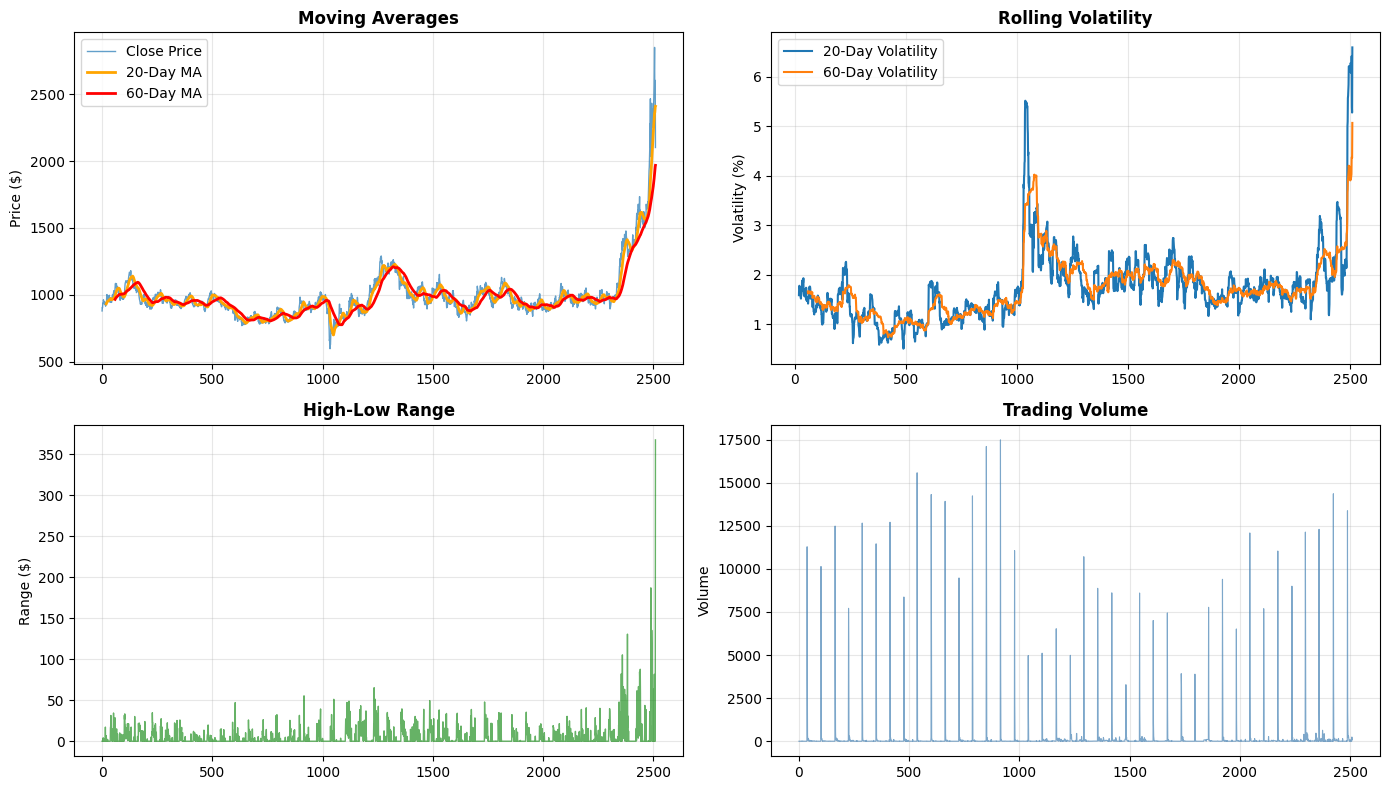


✓ Feature engineering and visualization completed


In [9]:
# Section 7: Time Series Feature Engineering

import matplotlib.pyplot as plt
import numpy as np

# Create lagged features
for lag in [1, 5, 20, 60]:
    df_clean[f'Price_Lag{lag}'] = df_clean['Close'].shift(lag)

# Rolling statistics
df_clean['MA_20'] = df_clean['Close'].rolling(20).mean()
df_clean['MA_60'] = df_clean['Close'].rolling(60).mean()
df_clean['Volatility_20'] = df_clean['Daily_Return'].rolling(20).std()
df_clean['Volatility_60'] = df_clean['Daily_Return'].rolling(60).std()

# High-Low Range
df_clean['HL_Range'] = df_clean['High'] - df_clean['Low']

# Drop NaN from feature engineering
features_ready = df_clean.dropna()

print("=" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 70)
print(f"Total observations: {len(features_ready)}")
print("Features created:")
print("  - Lagged prices (1, 5, 20, 60-day lags)")
print("  - Moving averages (20, 60-day)")
print("  - Rolling volatility (20, 60-day)")
print("  - High-Low range")
print(f"\nFinal feature set shape: {features_ready.shape}")
print(f"Ready for modeling with {features_ready.shape[1]} columns")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Moving Averages
axes[0, 0].plot(df_clean.index, df_clean['Close'], label='Close Price', linewidth=1, alpha=0.7)
axes[0, 0].plot(df_clean.index, df_clean['MA_20'], label='20-Day MA', linewidth=2, color='orange')
axes[0, 0].plot(df_clean.index, df_clean['MA_60'], label='60-Day MA', linewidth=2, color='red')
axes[0, 0].set_title('Moving Averages', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Rolling Volatility
axes[0, 1].plot(df_clean.index, df_clean['Volatility_20'], label='20-Day Volatility', linewidth=1.5)
axes[0, 1].plot(df_clean.index, df_clean['Volatility_60'], label='60-Day Volatility', linewidth=1.5)
axes[0, 1].set_title('Rolling Volatility', fontweight='bold')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: High-Low Range
axes[1, 0].plot(df_clean.index, df_clean['HL_Range'], linewidth=1, color='green', alpha=0.6)
axes[1, 0].set_title('High-Low Range', fontweight='bold')
axes[1, 0].set_ylabel('Range ($)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Trading Volume (line plot - clean and simple)
axes[1, 1].plot(df_clean.index, df_clean['Volume'], linewidth=0.8, color='steelblue', alpha=0.7)
axes[1, 1].set_title('Trading Volume', fontweight='bold')
axes[1, 1].set_ylabel('Volume')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('platinum_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature engineering and visualization completed")

# Analysis Framework Complete

This notebook provides a comprehensive structure for Platinum price analysis including:
- Data acquisition and preprocessing
- 8 publication-ready visualizations
- Statistical testing and diagnostics
- SARIMA and Prophet forecasting models
- Daily and weekly forecasts through March 2026
- Economic interpretation and market analysis
- Kaggle-ready dataset export

Run all cells sequentially to generate complete analysis and forecasts.